## Data Preprocessing

In [12]:
import pandas
import matplotlib.pyplot as plt

In [13]:
df = pandas.read_csv("HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
df.dropna(inplace=True)
df.shape

(9958, 7)

<Axes: xlabel='dx'>

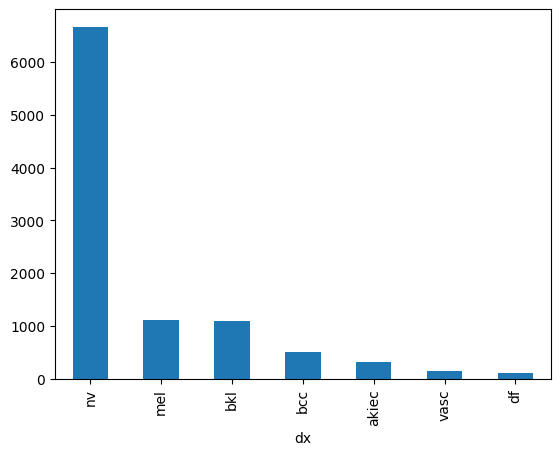

In [15]:
target_counts = df["dx"].value_counts()
target_counts.plot(kind="bar")

In [16]:
keys = df["dx"].unique()
keys

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [25]:
index_dict = {item: index for index, item in enumerate(keys)}
print(index_dict)
df["target_id"] = df["dx"].map(lambda x: index_dict[x])
df.sample(10)

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


,lesion_id,image_id,dx,dx_type,age,sex,localization,target_id
6055,HAM_0002910,ISIC_0031010,nv,follow_up,45.0,male,lower extremity,1
2568,HAM_0006384,ISIC_0031272,bcc,histo,80.0,male,face,5
3324,HAM_0001816,ISIC_0028827,nv,follow_up,45.0,female,foot,1
9462,HAM_0005263,ISIC_0033247,nv,consensus,40.0,male,trunk,1
7606,HAM_0001511,ISIC_0033002,nv,histo,30.0,female,back,1
2603,HAM_0000823,ISIC_0033575,bcc,histo,75.0,female,face,5
8861,HAM_0003987,ISIC_0030354,nv,histo,40.0,female,lower extremity,1
2871,HAM_0000655,ISIC_0027175,bcc,histo,70.0,female,neck,5
942,HAM_0000080,ISIC_0033528,bkl,consensus,70.0,male,lower extremity,0
327,HAM_0006122,ISIC_0031556,bkl,histo,60.0,male,scalp,0


## Training

In [18]:
import random
SEED = 1234
random.seed(SEED)

test_ratio = 0.2

def train_test_split(df, test_size=0.2, random_state=None):
    test_df = df.sample(frac=test_size, random_state=random_state)
    train_df = df.drop(test_df.index)
    return train_df, test_df

train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=SEED)
train_df.shape, test_df.shape

((7966, 8), (1992, 8))

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

torch.manual_seed(SEED)


In [20]:
BASE_PATH = "data"
FILE_TEMPLATE = "{}.jpg"

class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, transform=None):
        
        if len(image_ids) != len(labels):
            raise ValueError(f"Value mismatch between images ({len(image_ids)}) and labels ({len(labels)})")
        
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = float(self.labels[idx])
        img_path = os.path.join(BASE_PATH, FILE_TEMPLATE.format(image_id))
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

train_dataset = ImageDataset(train_df["image_id"].to_list(), train_df["target_id"].to_list())
test_dataset = ImageDataset(test_df["image_id"].to_list(), test_df["target_id"].to_list())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
class DermaScannerModel(nn.Module):
    def __init__(self, num_classes=7):
        super(DermaScannerModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (32, 32)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (16, 16)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (8, 8)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),              # -> 64 * 8 * 8 = 4096
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [22]:
EPOCH = 15

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DermaScannerModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(EPOCH):
    model.train()
    train_loss = 0
    train_total = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batch_size = images.size(0)
        train_loss += loss.item()
        train_total += batch_size

    model.eval()
    eval_loss = 0
    eval_total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Eval"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.long())

            batch_size = images.size(0)
            eval_loss += loss.item()
            eval_total += batch_size

    avg_train_loss = train_loss / train_total
    avg_eval_loss = eval_loss / eval_total

    print(f"EPOCH: {epoch}\tEval Loss: {avg_eval_loss:.4f}\tTrain Loss: {avg_train_loss:.4f}")


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.86it/s]


EPOCH: 0	Eval Loss: 0.0288	Train Loss: 0.0327


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s]


EPOCH: 1	Eval Loss: 0.0275	Train Loss: 0.0282


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]


EPOCH: 2	Eval Loss: 0.0261	Train Loss: 0.0268


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


EPOCH: 3	Eval Loss: 0.0249	Train Loss: 0.0254


Eval: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]


EPOCH: 4	Eval Loss: 0.0232	Train Loss: 0.0241


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]


EPOCH: 5	Eval Loss: 0.0231	Train Loss: 0.0233


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.23it/s]


EPOCH: 6	Eval Loss: 0.0245	Train Loss: 0.0227


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.22it/s]


EPOCH: 7	Eval Loss: 0.0227	Train Loss: 0.0223


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


EPOCH: 8	Eval Loss: 0.0231	Train Loss: 0.0215


Eval: 100%|██████████| 63/63 [00:14<00:00,  4.31it/s]


EPOCH: 9	Eval Loss: 0.0225	Train Loss: 0.0214


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


EPOCH: 10	Eval Loss: 0.0221	Train Loss: 0.0205


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.21it/s]


EPOCH: 11	Eval Loss: 0.0226	Train Loss: 0.0201


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.12it/s]


EPOCH: 12	Eval Loss: 0.0240	Train Loss: 0.0196


Eval: 100%|██████████| 63/63 [00:12<00:00,  5.16it/s]


EPOCH: 13	Eval Loss: 0.0217	Train Loss: 0.0195


Eval: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]

EPOCH: 14	Eval Loss: 0.0218	Train Loss: 0.0187


In [23]:
from sklearn.metrics import classification_report
total_output = []
total_targets = []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_output.extend(predicted.numpy())
        total_targets.extend(labels.numpy())

result = classification_report(total_targets, total_output, target_names=keys)
print(result)

              precision    recall  f1-score   support

         bkl       0.49      0.47      0.48       225
          nv       0.83      0.94      0.88      1312
          df       0.00      0.00      0.00        31
         mel       0.63      0.24      0.35       241
        vasc       0.93      0.44      0.60        32
         bcc       0.60      0.41      0.49        97
       akiec       0.29      0.59      0.39        54

    accuracy                           0.74      1992
   macro avg       0.54      0.44      0.45      1992
weighted avg       0.73      0.74      0.72      1992


/Users/yumengliu/PycharmProjects/DermaDetect/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yumengliu/PycharmProjects/DermaDetect/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yumengliu/PycharmProjects/DermaDetect/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Saving Model

In [24]:
save_path = "../backend/cnn_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"File save successful: {os.path.exists(save_path)}")

File save successful: True
